Programming an actual gate sequence for a 2D PSB measurement. Not worrying about actual measurement parts for now. The gate sequence has the following sections:

0. **Set home location.** Due to AC-coupled lines, this is where there is 0 bias on the AC line contributions. Set this in (1,3) or (3,1).
1. **Pulse P1 and P2 -- mixed state preparation.** Pulse into (0,4) (or (4,0)) for 600 us.
2. **Settle.** Pulse home and allow for caps to discharge. 2 ms or so.
3. **Pulse J.** J is DC-coupled or GB controlled, so we don't care how long it stays at a particular location.
4. **Read reference.** This is to offset the gradient in a 2D sweep/
5. **Pulse P1 and P2.** These gates need a ramp that is dependent on pulse amplitude. Compensates for AC decay.
6. **Readout.**
7. **SET feedback.**

In this notebook, we are targeting steps 1-3, 5. Readout can be easily integrated once we figure it out, same with feedback. Step 0 is prior calibration.

If only doing a 1D sweep, skip steps 3 and 4.

In [873]:
%matplotlib inline
import local_broom

In [3]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

import time
from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_5672\652053071.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [874]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [875]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
    "J": device.sgchannels[3],  # drive PJ line
}

drive_chans = ["P1", "P2", "J"]  # match keys above

In [7]:
NUM_READOUTS = 5

In [565]:
# synth = chan["P1"].synthesizer()
# synth = chan["P2"].synthesizer()

with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(0)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1) # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger
        # chan[c].generator.configure_sequencer_triggering(
        #     aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        #     play_pulse_delay=0
        #     )


## Basic Triggering and alignment

Uses P1 and P2 only, and just basicl square pulses to start...

In [566]:
seqc_program_p1 = """\
// Define waveform
wave w_p1_mixed = ones(2048);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_p1_mixed, 0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
waitDigTrigger(1);
setTrigger(1);
setTrigger(0);

// Mixed preparation, P1 only

executeTableEntry(0);            // fixed pulse amp and len P1
playZero(1024);                  // wait and settle
executeTableEntry(2); 

"""

seqc_program_p2 = """\
// Define waveform
wave w_p2_mixed = ones(2048);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_p2_mixed, 1);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
waitDigTrigger(1);
setTrigger(1);
setTrigger(0);

// Mixed preparation, P2 only
executeTableEntry(1);            // fixed pulse amp and len P2
playZero(1024);                  // wait and settle
executeTableEntry(3); 

"""


device.sgchannels[1].awg.load_sequencer_program(seqc_program_p1)  # P1
device.sgchannels[2].awg.load_sequencer_program(seqc_program_p2)  # P2

ct_schema_p1 = device.sgchannels[1].awg.commandtable.load_validation_schema()
ct_schema_p2 = device.sgchannels[2].awg.commandtable.load_validation_schema()
ct_p1 = CommandTable(ct_schema_p1)
ct_p2 = CommandTable(ct_schema_p2)

gain = 0.9

## Waveform with amplitude and phase settings
ct_p1.table[0].waveform.index = 0
ct_p1.table[0].amplitude00.value = gain
ct_p1.table[0].amplitude01.value = -gain
ct_p1.table[0].amplitude10.value = gain
ct_p1.table[0].amplitude11.value = gain
ct_p1.table[0].phase.value = 0

ct_p2.table[1].waveform.index = 1
ct_p2.table[1].amplitude00.value = -gain
ct_p2.table[1].amplitude01.value = gain
ct_p2.table[1].amplitude10.value = gain
ct_p2.table[1].amplitude11.value = gain
ct_p2.table[1].phase.value = 0

ct_p1.table[2].waveform.index = 0
ct_p1.table[2].amplitude00.value = gain/2
ct_p1.table[2].amplitude01.value = -gain/2
ct_p1.table[2].amplitude10.value = gain/2
ct_p1.table[2].amplitude11.value = gain/2
ct_p1.table[2].phase.value = 0

ct_p2.table[3].waveform.index = 1
ct_p2.table[3].amplitude00.value = -gain/2
ct_p2.table[3].amplitude01.value = gain/2
ct_p2.table[3].amplitude10.value = gain/2
ct_p2.table[3].amplitude11.value = gain/2
ct_p2.table[3].phase.value = 0

# ct.as_dict() 

device.sgchannels[1].awg.commandtable.upload_to_device(ct_p1)
device.sgchannels[2].awg.commandtable.upload_to_device(ct_p2)

In [569]:
device.system.internaltrigger.enable(0)

device.sgchannels[1].awg.enable_sequencer(single = 1)
device.sgchannels[2].awg.enable_sequencer(single = 1)

#device.system.internaltrigger.holdoff()
device.system.internaltrigger.enable(1)

## Using the Ramp Function

Instead of square pulses, transform into pulse and ramp...

TODO: Tune the ramp

In [428]:
seqc_program_ramp_test = """\
// Define waveform
wave w_p1_ramp = ramp(4096, 0.5, 0.6); // samples, start level, end level

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_p1_ramp, 0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
waitDigTrigger(1);
setTrigger(1);
setTrigger(0);

// Mixed preparation, P1 only

executeTableEntry(0);            // ramp P1
playZero(1024);                  // wait and settle
executeTableEntry(2);            // ramp P1 again

"""

In [429]:
# create command table
device.sgchannels[1].awg.load_sequencer_program(seqc_program_ramp_test)  # P1
ct_schema_p1_ramp = device.sgchannels[1].awg.commandtable.load_validation_schema()
ct_p1_ramp = CommandTable(ct_schema_p1_ramp)

gain = 0.9

## Waveform with amplitude and phase settings
ct_p1_ramp.table[0].waveform.index = 0
ct_p1_ramp.table[0].amplitude00.value = gain
ct_p1_ramp.table[0].amplitude01.value = -gain
ct_p1_ramp.table[0].amplitude10.value = gain
ct_p1_ramp.table[0].amplitude11.value = gain
ct_p1_ramp.table[0].phase.value = 0
ct_p1_ramp.table[2].waveform.length = 1024

ct_p1_ramp.table[2].waveform.index = 0
ct_p1_ramp.table[2].amplitude00.value = gain/2
ct_p1_ramp.table[2].amplitude01.value = -gain/2
ct_p1_ramp.table[2].amplitude10.value = gain/2
ct_p1_ramp.table[2].amplitude11.value = gain/2
ct_p1_ramp.table[2].phase.value = 0
ct_p1_ramp.table[2].waveform.length = 4096

device.sgchannels[1].awg.commandtable.upload_to_device(ct_p1_ramp)

In [430]:
device.system.internaltrigger.enable(0)

device.sgchannels[1].awg.enable_sequencer(single = 1)

device.system.internaltrigger.enable(1)

This is fine, but it lacks controllability that we need for ramped pulses (i.e. changing the length doesn't seem to work, and its hard to change the ramp rate too if needed. Ramp rate changes based on length as well, bad). Let's go to version two, where we do placeholder waves

In [570]:
seqc_program_ramp_test2 = """\
// Define two wave table entries through placeholders
assignWaveIndex(1,2, placeholder(2048), 0);
// assignWaveIndex(1,2, placeholder(64), 1);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
setTrigger(1);
setTrigger(0);

// execute command table
executeTableEntry(0);
playZero(1024);
executeTableEntry(1);
// executeTableEntry(2);
"""

## Upload sequence
device.sgchannels[1].awg.load_sequencer_program(seqc_program_ramp_test2)

{'messages': '', 'maxelfsize': 2147483648}

In [571]:
## parameters for waveform generation
amp = 0.5
length = 2048
ramp_rate = 5e-5
pulseAndRamp = np.linspace(amp, amp + amp*length*ramp_rate, length)

## define waveforms as list of real-values arrays - here: Gaussian functions
waves = [[pulseAndRamp]]

## upload waveforms to instrument
waveforms = Waveforms()
for i, wave in enumerate(waves):
    waveforms[i] = (wave[0])

device.sgchannels[1].awg.write_to_waveform_memory(waveforms)

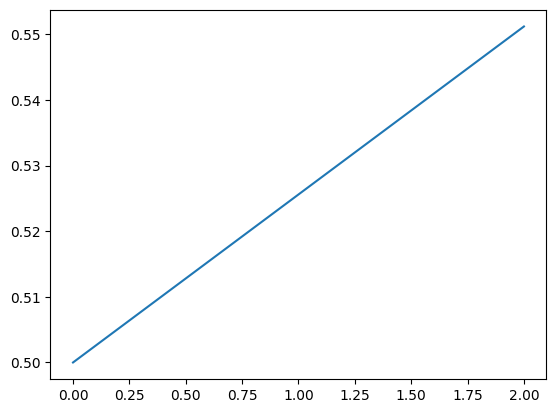

In [536]:
import matplotlib.pyplot as plt

plt.plot(x_1, waves[0][0])

In [572]:
# # create command table
# device.sgchannels[1].awg.load_sequencer_program(seqc_program_ramp_test2)  # P1
# ct_schema_p1_ramp2 = device.sgchannels[1].awg.commandtable.load_validation_schema()
# ct_p1_ramp2 = CommandTable(ct_schema_p1_ramp2)

# gain = 0.9

# ## Waveform with amplitude and phase settings
# ct_p1_ramp2.table[0].waveform.index = 0
# ct_p1_ramp2.table[0].amplitude00.value = gain
# ct_p1_ramp2.table[0].amplitude01.value = -gain
# ct_p1_ramp2.table[0].amplitude10.value = gain
# ct_p1_ramp2.table[0].amplitude11.value = gain
# ct_p1_ramp2.table[0].phase.value = 0
# ct_p1_ramp2.table[2].waveform.length = 1024

# ct_p1_ramp2.table[2].waveform.index = 0
# ct_p1_ramp2.table[2].amplitude00.value = gain/2
# ct_p1_ramp2.table[2].amplitude01.value = -gain/2
# ct_p1_ramp2.table[2].amplitude10.value = gain/2
# ct_p1_ramp2.table[2].amplitude11.value = gain/2
# ct_p1_ramp2.table[2].phase.value = 0
# ct_p1_ramp2.table[2].waveform.length = 4096

# device.sgchannels[1].awg.commandtable.upload_to_device(ct_p1_ramp2)

## Define command table
## Initialize command table
ct_schema = device.sgchannels[1].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

gain = 0.6

## Waveform 0 with oscillator 1
ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude11.value = gain
ct.table[0].phase.value = 0.0
ct.table[0].waveform.length = 2048

# ## Waveform 1 with oscillator 2
ct.table[1].waveform.index = 0
ct.table[1].amplitude00.value = -gain
ct.table[1].amplitude01.value = gain
ct.table[1].amplitude10.value = gain
ct.table[1].amplitude11.value = gain
ct.table[1].phase.value = 0.0
ct.table[1].waveform.length = 256

# ## Waveform 1 with oscillator 1 and different phase
# ct.table[2].waveform.index = 0
# ct.table[2].amplitude00.value = gain
# ct.table[2].amplitude01.value = -gain
# ct.table[2].amplitude10.value = gain
# ct.table[2].amplitude11.value = gain
# ct.table[2].phase.value = 90.0
# ct.table[2].waveform.length = 512

## Upload command table
device.sgchannels[1].awg.commandtable.upload_to_device(ct)

In [573]:
device.system.internaltrigger.enable(0)

device.sgchannels[1].awg.enable_sequencer(single = 1)

device.system.internaltrigger.enable(1)

#device.sgchannels[1].awg.enable_sequencer(single = 1)

## Complete Pulse Sequence (minus readout)

Integrates J-gate pulsing too. This part is optional if you only want 1-D sweeps.

TODO: Make sure all the timing are correct, synced, and sane.
- Init, wait, and readout times (basically all here) are somewhat hardcoded, as these timings we will never need to change

In [757]:
seqc_program_p1 = """\
// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, placeholder(2048), 0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
waitDigTrigger(1);
setTrigger(1);
setTrigger(0);

executeTableEntry(0);            // mixed state init.
playZero(1024);                  // wait and settle
playZero(1024);                  // read reference
executeTableEntry(2);            // read

"""

seqc_program_p2 = """\
// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, placeholder(2048), 0);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
waitDigTrigger(1);
setTrigger(1);
setTrigger(0);

executeTableEntry(1);            // mixed state init.
playZero(1024);                  // wait and settle
playZero(1024);                  // read reference
executeTableEntry(3);            // read
"""

seqc_program_j = """\
// Define waveform
wave w_j_mixed = ones(2048);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_j_mixed, 2);

// Reset the oscillator phase
resetOscPhase();

// Trigger the scope
waitDigTrigger(1);
setTrigger(1);
setTrigger(0);

playZero(2048);                  // mixed state init
playZero(1024);                  // wait and settle
executeTableEntry(4);            // read referemce, read
"""

## Upload sequence
chan["P1"].awg.load_sequencer_program(seqc_program_p1)
chan["P2"].awg.load_sequencer_program(seqc_program_p2)
chan["J"].awg.load_sequencer_program(seqc_program_j)


{'messages': '', 'maxelfsize': 2147483648}

In [758]:
# CREATING THE RAMP PULSES

## parameters for waveform generation
amp = 0.5
length = 2048
ramp_rate = 5e-5
pulseAndRamp = np.linspace(amp, amp + amp*length*ramp_rate, length)

## define waveforms as list of real-values arrays - here: Gaussian functions
waves = [[pulseAndRamp]]

## upload waveforms to instrument
waveforms = Waveforms()
for i, wave in enumerate(waves):
    waveforms[i] = (wave[0])

chan["P1"].awg.write_to_waveform_memory(waveforms)
chan["P2"].awg.write_to_waveform_memory(waveforms)

In [669]:
# TIMING AND VOLTAGE FUNCTIONS

def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

def voltToDbm(volt, dbmrange):
    '''WIP. Returns a normalized amplitude given a dBm output range. 
    Calibrated using scope, and doing it a shit way (not real conversion).
    See page 47 of manual.
    Volts given in units of V.'''
    amp = volt / 0.340
    if volt > 0.340 or volt < -0.340:
        raise ValueError("Given voltage is greater than max output of SHFQC (+-0.34 V)")
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")

    return amp

In [799]:
timeToSamples(2e-6, 3)

496

In [759]:
ct_schema_p1 = chan["P1"].awg.commandtable.load_validation_schema()
ct_schema_p2 = chan["P2"].awg.commandtable.load_validation_schema()
ct_schema_j = chan["J"].awg.commandtable.load_validation_schema()
ct_p1 = CommandTable(ct_schema_p1)
ct_p2 = CommandTable(ct_schema_p2)
ct_j = CommandTable(ct_schema_j)

samplingDivider = 3

# amplitudes (maximum 340mV, give in terms of V)
init_amp = 0.3
read_amp = 0.3
read_amp_j = 0.2

# timings in seconds
init_len = 1e-6       # 600 us
read_len = 2e-6       # 100 us
read_len_j = 1e-6     # 100 us (read ref) + 100 us  (read) + any intermediate wait time

## Waveform with amplitude and phase settings
ct_p1.table[0].waveform.index = 0
ct_p1.table[0].amplitude00.value = voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].amplitude01.value = -voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].amplitude10.value = voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].amplitude11.value = voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].waveform.length = timeToSamples(init_len, samplingDivider)
ct_p1.table[0].waveform.samplingRateDivider = samplingDivider

ct_p2.table[1].waveform.index = 0
ct_p2.table[1].amplitude00.value = -voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].amplitude01.value = voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].amplitude10.value = voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].amplitude11.value = voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].waveform.length = timeToSamples(init_len, samplingDivider)
ct_p2.table[1].waveform.samplingRateDivider = samplingDivider

ct_p1.table[2].waveform.index = 0
ct_p1.table[2].amplitude00.value = voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].amplitude01.value = -voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].amplitude10.value = voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].amplitude11.value = voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].waveform.length = timeToSamples(read_len, samplingDivider)
ct_p1.table[2].waveform.samplingRateDivider = samplingDivider

ct_p2.table[3].waveform.index = 0
ct_p2.table[3].amplitude00.value = -voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].amplitude01.value = voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].amplitude10.value = voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].amplitude11.value = voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].waveform.length = timeToSamples(read_len, samplingDivider)
ct_p2.table[3].waveform.samplingRateDivider = samplingDivider

ct_j.table[4].waveform.index = 2
ct_j.table[4].amplitude00.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].amplitude01.value = -voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].amplitude10.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].amplitude11.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].waveform.length = timeToSamples(read_len_j, samplingDivider)
ct_j.table[4].waveform.samplingRateDivider = samplingDivider


# ct.as_dict() 

chan["P1"].awg.commandtable.upload_to_device(ct_p1)
chan["P2"].awg.commandtable.upload_to_device(ct_p2)
chan["J"].awg.commandtable.upload_to_device(ct_j)

In [760]:
device.system.internaltrigger.enable(0)

chan["P1"].awg.enable_sequencer(single = 1)
chan["P2"].awg.enable_sequencer(single = 1)
chan["J"].awg.enable_sequencer(single = 1)

#device.system.internaltrigger.holdoff()
device.system.internaltrigger.enable(1)

## Simple Pulse + Readout

Just doing a single square pulse on a gate, then another square pulse and readout on that second pulse.

This code ended up being pure chaos, I'd avoid basing other things on this, just move onto what's next...

In [682]:
def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

In [1105]:
with device.set_transaction():
    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(406.6e6)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(0.95)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(512)  # integration time length in units of number of samples (usually  integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code

    # setup result parameters
    chan["measure"].spectroscopy.result.averages(1)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(64)  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz
        input_range=-20,  # in units of dBm
        output_range=-20,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

chan["measure"].generator.auxtriggers[1].channel("inttrig")

chan["measure"].generator.configure_sequencer_triggering(
    aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
    play_pulse_delay=0
)


In [1106]:
num_avgs = 3  # should reorder everything to define all variables in one place

seq_readout = f"""
setTrigger(0);
repeat ({num_avgs}) {{
    // wait for a digital trigger before starting (defined by the aux_trigger)
    waitDigTrigger(1);

    // delay before readout
    playZero(128+16*3); // time before readout A (224 samples = lines up with SG trigger)
    playZero(64);  // readout time B:

    // if using an envelope make sure to open it
    //startQA(QA_GEN_ALL, QA_INT_ALL, true, 0, 0x0);  // also send sequence monitor trigger (true)

    // set trigger output 1 to 1 then 0. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(1);
    setTrigger(0);

    playZero(32); // relax time C (just wait for above readout to finish)
}}
"""

seq_program_j = f'''
    wave w_j_mixed = ones(2048);
    assignWaveIndex(1,2, w_j_mixed, 0);
    repeat({num_avgs}) {{
    
        waitDigTrigger(1);
        setTrigger(1);
        setTrigger(0);
        
        // demo J pulse
        
        executeTableEntry(0);            // first pulse
        playZero(1024);                  // wait and settle
        executeTableEntry(2);
    }}
'''

chan["J"].awg.load_sequencer_program(seq_program_j)
chan["measure"].generator.load_sequencer_program(seq_readout)

{'messages': '', 'maxelfsize': 2147483648}

In [1107]:
ct_schema_j = chan["J"].awg.commandtable.load_validation_schema()
ct_j = CommandTable(ct_schema_j)

samplingDivider = 3

# amplitudes (maximum 340mV, give in terms of V)
read_amp_j = 0.2

# timings in seconds
read_len_j = 2e-6     # 100 us (read ref) + 100 us  (read) + any intermediate wait time
buffer = 10e-6

## Waveform with amplitude and phase settings
ct_j.table[0].waveform.index = 0
ct_j.table[0].amplitude00.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[0].amplitude01.value = -voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[0].amplitude10.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[0].amplitude11.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[0].waveform.length = timeToSamples(read_len_j, samplingDivider)
ct_j.table[0].waveform.samplingRateDivider = samplingDivider

ct_j.table[2].waveform.index = 0
ct_j.table[2].amplitude00.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[2].amplitude01.value = -voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[2].amplitude10.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[2].amplitude11.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[2].waveform.length = timeToSamples(read_len_j, samplingDivider)
ct_j.table[2].waveform.samplingRateDivider = samplingDivider

chan["J"].awg.commandtable.upload_to_device(ct_j)

In [731]:
device.system.internaltrigger.enable(0)

chan["J"].awg.enable_sequencer(single = 1)

device.system.internaltrigger.enable(1)

In [1108]:
# when using the internal trigger to start things (not used now)
device.system.internaltrigger.repetitions(num_avgs)  # make sure that this matches how many repetitions for each awg sequencer
device.system.internaltrigger.holdoff(2*read_len_j + buffer)  # how long to wait between retriggers (increments of 100ns)
device.system.internaltrigger.enable(0)

In [1109]:
result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

chan["measure"].spectroscopy.result.enable(1)  # start logger

# start sequencers
# chan["ST"].awg.enable(1)
chan["measure"].generator.enable_sequencer(single=True)

# start triggering sequence (which starts each sequencer)
# use Software Trigger
#device.start_continuous_sw_trigger(num_triggers=NUM_READOUTS, wait_time=2e-3)  # use software trigger with 2ms delay between measurements
# use Internal Trigger
device.system.internaltrigger.enable(1)

pbar = tqdm(total=100)
while device.system.internaltrigger.progress() != 1.0:
    p = int(device.system.internaltrigger.progress()*100)
    pbar.update(p-pbar.n)
    time.sleep(0.001)
pbar.update(100-pbar.n)
pbar.close()

chan["measure"].spectroscopy.result.enable(0)  # stop data logger

# get results
results = get_results(result_node, timeout=2)
result_node.unsubscribe()

acq = chan["measure"].spectroscopy.result.acquired()
#if len(results) > acq:
#    raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

  0%|          | 0/100 [00:00<?, ?it/s]

## A Comprehensive Pulse and Readout

A complete and better laid out code that incorporates the previous gate pulses as well as a readout section. Things are less hardcoded now too. Lots of repeated code from before, this section more or less should stand on its own

In [1121]:
# VARIABLES

# gate sampling time
samplingDivider = 3


# readout signals
readout_gain = 0.95
readout_freq = 406.6e6


# averaging
num_avgs = 4


# drive line amplitudes (maximum 340mV, give in terms of V)
init_amp = 0.02 * 10  # *10 compensates weird quirk between interaction of voltToDbm function, pulseAndRamp array, and SHFQC behaviour...
read_amp = 0.02 * 10
read_amp_j = 0.2

ramp_rate = 6.8e-6  # hopefully this is calibrated to 250 MHz sample rate (V/s)


# timings in seconds CLEAN UP VARIABLES
wait_and_settle = 100e-6
buffer = 0.1e-6

init_len = 400e-6       # 600 us
read_len = 100e-6       # 100 us, 
read_len_j = 2*read_len + buffer    # 100 us (read ref) + 100 us  (read) + any intermediate wait time



In [1122]:
# FUNCTIONS

def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

def voltToDbm(volt, dbmrange):
    '''WIP. Returns a normalized amplitude given a dBm output range. 
    Calibrated using scope, and doing it a shit way (not real conversion).
    See page 47 of manual.
    Volts given in units of V.
    There is an odd bug (feature?) here, where if the amplitude exceeds 1 (e.g. 1.1), it wraps around and becomes -0.1, 
    and 2.1 becomes 0.1 etc.
    This shouldn't be a problem, but it manifests in the pulseAndRamp array as this takes default values of 0.34V for 1:1
    scaling, flipping P1 and P2 voltages around.
    The fix is to decrease the default values down by 10x, and increase input voltages 10x, and everything is happy.
    If you want to change this to a more sane method, go ahead.'''
    amp = volt / 0.340
    # if volt > 0.340 or volt < -0.340:
    #     raise ValueError("Given voltage is greater than max output of SHFQC (+-0.34 V)")
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")
    return amp

def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

In [1123]:
# CHANNEL SETTINGS

# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
    "J": device.sgchannels[3],  # drive PJ line
}

drive_chans = ["P1", "P2", "J"]  # match keys above

with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(0)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1) # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(406.6e6)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(0.95)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(timeToSamples(read_len, samplingDivider))  # integration time length in units of number of samples (usually  integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code

    # setup result parameters
    chan["measure"].spectroscopy.result.averages(num_avgs)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(2)  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz
        input_range=-20,  # in units of dBm
        output_range=-20,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    chan["measure"].generator.auxtriggers[1].channel("inttrig")

    chan["measure"].generator.configure_sequencer_triggering(
        aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        play_pulse_delay=0
    )


In [1124]:
# SEQUENCES

seqc_program_p1 = f"""
// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, placeholder({timeToSamples(init_len, samplingDivider)}), 0);

// Reset the oscillator phase
resetOscPhase();

repeat({num_avgs}) {{

    // Trigger the scope
    waitDigTrigger(1);
    setTrigger(1);
    setTrigger(0);
    
    executeTableEntry(0);            // mixed state init.
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
    playZero({timeToSamples(read_len, samplingDivider)}, AWG_RATE_250MHZ);        // read reference
    playZero({timeToSamples(buffer, samplingDivider)}, AWG_RATE_250MHZ);              // buffer
    executeTableEntry(2);            // read
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
}}
"""

seqc_program_p2 = f"""
// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, placeholder({timeToSamples(init_len, samplingDivider)}), 0);

// Reset the oscillator phase
resetOscPhase();

repeat({num_avgs}) {{

    // Trigger the scope
    waitDigTrigger(1);
    setTrigger(1);
    setTrigger(0);
    
    executeTableEntry(1);            // mixed state init.
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
    playZero({timeToSamples(read_len, samplingDivider)}, AWG_RATE_250MHZ);        // read reference
    playZero({timeToSamples(buffer, samplingDivider)}, AWG_RATE_250MHZ);              // buffer
    executeTableEntry(3);            // read
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
}}
"""

seqc_program_j = f"""
// Define waveform
wave w_j_mixed = ones({timeToSamples(init_len, samplingDivider)});

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_j_mixed, 2);

// Reset the oscillator phase
resetOscPhase();

repeat({num_avgs}) {{

    // Trigger the scope
    waitDigTrigger(1);
    setTrigger(1);
    setTrigger(0);
    
    playZero({timeToSamples(init_len, samplingDivider)}, AWG_RATE_250MHZ);            // mixed state init
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
    executeTableEntry(4);            // read referemce, read
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
}}
"""

seqc_readout = f"""
setTrigger(0);

repeat({num_avgs}) {{

    // wait for a digital trigger before starting (defined by the aux_trigger)
    waitDigTrigger(1);
    
    // delay before readout
    // time before reference readout
    playZero({timeToSamples(init_len, samplingDivider) + timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ); 
    
    // set trigger output 1 to 1 then 0. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(1);
    setTrigger(0);
    
    playZero({timeToSamples(read_len + buffer, samplingDivider)}, AWG_RATE_250MHZ); // reference readout
    
    // set trigger output 1 to 1 then 0. As this matches "chan0seqtrig0" the spectroscopy is started
    setTrigger(1);
    setTrigger(0);
    
    playZero({timeToSamples(read_len, samplingDivider)}); // readout
    playZero({timeToSamples(wait_and_settle, samplingDivider)}, AWG_RATE_250MHZ);     // wait and settle
}}

"""

## Upload sequence
chan["P1"].awg.load_sequencer_program(seqc_program_p1)
chan["P2"].awg.load_sequencer_program(seqc_program_p2)
chan["J"].awg.load_sequencer_program(seqc_program_j)
chan["measure"].generator.load_sequencer_program(seq_readout)

{'messages': '', 'maxelfsize': 2147483648}

In [1125]:
# CREATING THE RAMP PULSES

pulseAndRamp = np.linspace(voltToDbm(0.034, 0), voltToDbm(0.034, 0) +
                           voltToDbm(0.034, 0)*timeToSamples(init_len, samplingDivider)*ramp_rate,
                           timeToSamples(init_len, samplingDivider))


# define waveforms as list of real-values arrays
waves = [[pulseAndRamp]]

# upload waveforms to instrument
waveforms = Waveforms()
for i, wave in enumerate(waves):
    waveforms[i] = (wave[0])

chan["P1"].awg.write_to_waveform_memory(waveforms)
chan["P2"].awg.write_to_waveform_memory(waveforms)

In [1126]:
# COMMAND TABLES

ct_schema_p1 = chan["P1"].awg.commandtable.load_validation_schema()
ct_schema_p2 = chan["P2"].awg.commandtable.load_validation_schema()
ct_schema_j = chan["J"].awg.commandtable.load_validation_schema()
ct_p1 = CommandTable(ct_schema_p1)
ct_p2 = CommandTable(ct_schema_p2)
ct_j = CommandTable(ct_schema_j)

## Waveform with amplitude and phase settings
ct_p1.table[0].waveform.index = 0
ct_p1.table[0].amplitude00.value = voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].amplitude01.value = -voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].amplitude10.value = voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].amplitude11.value = voltToDbm(init_amp, chan["P1"].output.range())
ct_p1.table[0].waveform.length = timeToSamples(init_len, samplingDivider)
ct_p1.table[0].waveform.samplingRateDivider = samplingDivider

ct_p2.table[1].waveform.index = 0
ct_p2.table[1].amplitude00.value = -voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].amplitude01.value = voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].amplitude10.value = voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].amplitude11.value = voltToDbm(init_amp, chan["P2"].output.range())
ct_p2.table[1].waveform.length = timeToSamples(init_len, samplingDivider)
ct_p2.table[1].waveform.samplingRateDivider = samplingDivider

ct_p1.table[2].waveform.index = 0
ct_p1.table[2].amplitude00.value = voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].amplitude01.value = -voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].amplitude10.value = voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].amplitude11.value = voltToDbm(read_amp, chan["P1"].output.range())
ct_p1.table[2].waveform.length = timeToSamples(read_len, samplingDivider)
ct_p1.table[2].waveform.samplingRateDivider = samplingDivider

ct_p2.table[3].waveform.index = 0
ct_p2.table[3].amplitude00.value = -voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].amplitude01.value = voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].amplitude10.value = voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].amplitude11.value = voltToDbm(read_amp, chan["P2"].output.range())
ct_p2.table[3].waveform.length = timeToSamples(read_len, samplingDivider)
ct_p2.table[3].waveform.samplingRateDivider = samplingDivider

ct_j.table[4].waveform.index = 2
ct_j.table[4].amplitude00.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].amplitude01.value = -voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].amplitude10.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].amplitude11.value = voltToDbm(read_amp_j, chan["J"].output.range())
ct_j.table[4].waveform.length = timeToSamples(read_len_j, samplingDivider)
ct_j.table[4].waveform.samplingRateDivider = samplingDivider


chan["P1"].awg.commandtable.upload_to_device(ct_p1)
chan["P2"].awg.commandtable.upload_to_device(ct_p2)
chan["J"].awg.commandtable.upload_to_device(ct_j)

In [1129]:
device.system.internaltrigger.repetitions(num_avgs)  # make sure that this matches how many repetitions for each awg sequencer
device.system.internaltrigger.holdoff(init_len + 2*wait_and_settle + 2*read_len + buffer)  # how long to wait between retriggers (increments of 100ns)
device.system.internaltrigger.enable(0)

result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

chan["measure"].spectroscopy.result.enable(1)  # start logger

# start sequencers
# chan["ST"].awg.enable(1)
chan["measure"].generator.enable_sequencer(single=True)
chan["P1"].awg.enable_sequencer(single = 1)
chan["P2"].awg.enable_sequencer(single = 1)
chan["J"].awg.enable_sequencer(single = 1)

# start triggering sequence (which starts each sequencer)
# use Software Trigger
#device.start_continuous_sw_trigger(num_triggers=NUM_READOUTS, wait_time=2e-3)  # use software trigger with 2ms delay between measurements
# use Internal Trigger
device.system.internaltrigger.enable(1)

pbar = tqdm(total=100)
while device.system.internaltrigger.progress() != 1.0:
    p = int(device.system.internaltrigger.progress()*100)
    pbar.update(p-pbar.n)
    time.sleep(0.001)
pbar.update(100-pbar.n)
pbar.close()

chan["measure"].spectroscopy.result.enable(0)  # stop data logger

# get results
results = get_results(result_node, timeout=2)
result_node.unsubscribe()


acq = chan["measure"].spectroscopy.result.acquired()
#if len(results) > acq:
#    raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

  0%|          | 0/100 [00:00<?, ?it/s]

{}


TimeoutError: Timeout before all samples collected.

In [1084]:
print(results)

[-0.00335209-0.01873605j -0.00055018-0.00388862j]


In [1033]:
print(read_len_j)

0.0004001


In [993]:
voltToDbm(0.35, 0)

1.0294117647058822